# Mongolian University Entrance Examination Results Analysis & Dashboard

## Project Overview

This project analyzes student performance data from the Mongolian University Entrance Examinations across multiple subjects and provinces. The objective is to consolidate various subject-specific exam datasets into a unified structure and develop interactive tools to uncover insights about student scores, regional disparities, percentile benchmarks, and exam participation trends.

The project follows a complete data science workflow, including data cleaning, exploratory data analysis (EDA), visualization, and predictive modeling.

## Objectives

- Understand the distribution and relationship between First Score and Converted Score across all subjects.
- Analyze regional disparities in exam performance across Mongolian provinces.
- Identify percentile thresholds and the score requirements to reach key benchmarks such as the 90th, 75th, and 50th percentiles.
- Build predictive models to estimate a student’s percentile based on their score.
- Develop two interactive tools for real-time filtering and visualization of results.

## Interactive Platforms

This project offers two platforms with similar functionalities for exploring the examination results:

### Streamlit App  
An interactive web application for:
- Visualizing trends and distributions across subjects and provinces
- Predicting percentiles using Machine Learning (Random Forest)
- Estimating percentile via ECDF (Empirical Cumulative Distribution Function)

[Open the Streamlit App] https://lookerstudio.google.com/reporting/51297d2d-2535-4117-9b0f-0931244e8104

### Google Looker Dashboard  
A business intelligence dashboard that provides:
- Filterable visualizations of exam results by subject, region, and score range
- Percentile thresholds and subject-specific score summaries
- Interactive geographic maps of exam taker distributions

[View the Looker Dashboard] https://zzzillo-mongolia-university-entrance-examina-1-dashboard-sjx8tr.streamlit.app/

### Import Necessary Datasets

In [36]:
#Import neccesary libraries
import pandas as pd
import os
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import plotly.express as px
import matplotlib.patches as mpatches
import json
import joblib
from statsmodels.distributions.empirical_distribution import ECDF
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_absolute_error

## Data Cleaning and Preprocessing

### Combining the Dataset into One Compiled Dataset

To ensure consistency and enable comprehensive analysis, all subject-specific exam datasets were loaded, assigned corresponding region names and ISO codes, and merged into a single unified dataset (`Combined Dataset.csv`). This consolidated file serves as the foundation for all visualizations, modeling, and dashboard components.


In [37]:
#Combining the Dataset
folder_path = "Dataset"

region_map = {
    1: "Arkhangai Province", 2: "Bayan-Ölgii Province", 3: "Bayankhongor Province",
    4: "Bulgan Province", 5: "Govi-Altai Province", 6: "Govisümber Province",
    7: "Darkhan-Uul Province", 8: "Dornogovi Province", 9: "Dornod Province",
    10: "Dundgovi Province", 11: "Zavkhan Province", 12: "Orkhon Province",
    13: "Övörkhangai Province", 14: "Ömnögovi Province", 15: "Sükhbaatar Province",
    16: "Selenge Province", 17: "Töv Province", 18: "Uvs Province", 19: "Khovd Province",
    20: "Khentii Province", 21: "Khövsgöl Province", 22: "Baganuur District", 23: "Ulaanbaatar City"
}

iso_map = {
    "Arkhangai Province": "MN-073", "Bayan-Ölgii Province": "MN-071", "Bayankhongor Province": "MN-069",
    "Bulgan Province": "MN-067", "Govi-Altai Province": "MN-065", "Govisümber Province": "MN-064",
    "Darkhan-Uul Province": "MN-037", "Dornogovi Province": "MN-063", "Dornod Province": "MN-061",
    "Dundgovi Province": "MN-059", "Zavkhan Province": "MN-057", "Orkhon Province": "MN-035",
    "Övörkhangai Province": "MN-055", "Ömnögovi Province": "MN-053", "Sükhbaatar Province": "MN-051",
    "Selenge Province": "MN-049", "Töv Province": "MN-047", "Uvs Province": "MN-046",
    "Khovd Province": "MN-043", "Khentii Province": "MN-039", "Khövsgöl Province": "MN-041",
    "Baganuur District": "MN-020", "Ulaanbaatar City": "MN-1"
}

all_data = []

folder_path = "Dataset"

for filename in os.listdir(folder_path):
    if filename.endswith(".csv"):
        file_path = os.path.join(folder_path, filename)
        subject = filename.replace(".csv", "").capitalize()
        
        # Load and process
        df = pd.read_csv(file_path)
        df["Subject"] = subject
        df["Region"] = df["Areacode"].map(region_map)
        df["ISO_Code"] = df["Region"].map(iso_map)
        
        all_data.append(df)

combined_df = pd.concat(all_data, ignore_index=True)
combined_df = combined_df.drop("Placement", axis=1)
output_path = "Combined Dataset.csv"
combined_df.to_csv(output_path, index=False)

### Generate Score Requirements by Percentile

This step calculates the required First Score and Converted Score to reach specific percentile thresholds (90%, 75%, 60%, 50%, 40%, 25%) for each subject. The resulting table is saved as a CSV (`Subject Percentile.csv`) to be used for visualizations and analysis in Google Looker. This helps identify how score requirements vary across subjects and percentile levels.


In [38]:
df = pd.read_csv("Combined Dataset.csv")

percentiles = [0.9, 0.75, 0.6, 0.5, 0.4, 0.25]
results = []

for subject, group in df.groupby("Subject"):
    for p in percentiles:
        results.append({
            "Subject": subject,
            "Percentile": f"{int(p * 100)}%",
            "Firstscore": round(group["Firstscore"].quantile(p), 2),
            "Convertedscore": round(group["Convertedscore"].quantile(p), 2)
        })

percentile_df = pd.DataFrame(results)
percentile_df.to_csv("Subject Percentile.csv", index=False)

In [39]:
# Load the dataset
df = pd.read_csv("Combined Dataset.csv")

## Exploratory Data Analysis

### First Scores Distribution

This histogram visualizes the distribution of students' raw First Scores across all subjects. It helps identify the overall performance trends and score concentration. As shown in the plot, most scores are concentrated on the lower end of the scale (left side), indicating that a large portion of examinees scored below the midpoint.


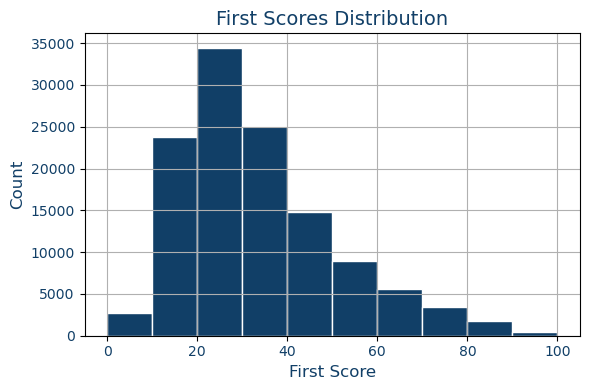

In [40]:
# Plot: First Scores Histogram
plt.figure(figsize=(6, 4))
sns.histplot(
    data=df,
    x="Firstscore",
    bins=10,
    color="#113f67",
    edgecolor="white",
    alpha=1
)
plt.title("First Scores Distribution", dict(size=14, color="#113f67"))
plt.xlabel("First Score", dict(size=12, color="#113f67"))
plt.ylabel("Count", dict(size=12, color="#113f67"))
plt.xticks(color="#113f67")
plt.yticks(color="#113f67")
plt.grid(True)
plt.tight_layout()
plt.show()


### Converted Scores Distribution

This histogram displays the distribution of Converted Scores, which are scaled versions of the raw First Scores. Unlike the raw scores, the converted scores show a more balanced and symmetric distribution, suggesting that the scaling process effectively normalized the data across subjects and regions.


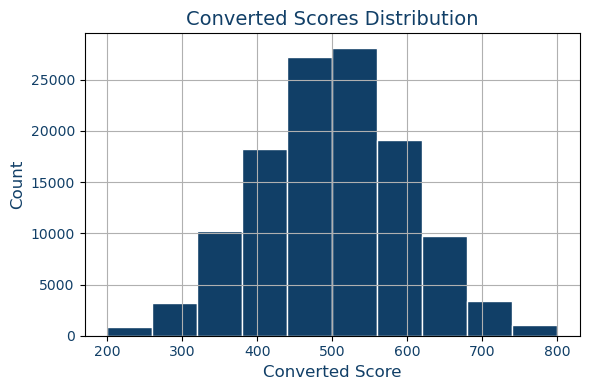

In [41]:
# Plot: Converted Scores Histogram
plt.figure(figsize=(6, 4))
sns.histplot(
    data=df,
    x="Convertedscore",
    bins=10,
    color="#113f67",
    edgecolor="white",
    alpha=1
)
plt.title("Converted Scores Distribution", dict(size=14, color="#113f67"))
plt.xlabel("Converted Score", dict(size=12, color="#113f67"))
plt.ylabel("Count", dict(size=12, color="#113f67"))
plt.xticks(color="#113f67")
plt.yticks(color="#113f67")
plt.grid(True)
plt.tight_layout()
plt.show()


### Distribution of Exam Takers by Province

This bar chart illustrates the number of exam takers across each province in Mongolia. Ulaanbaatar City stands out as the dominant contributor to the national exam data, highlighting a strong concentration of students in the capital compared to other regions.

/var/folders/zb/cc1txqfj67jbtr91_h72hwt00000gn/T/ipykernel_6053/1075225939.py:3: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.




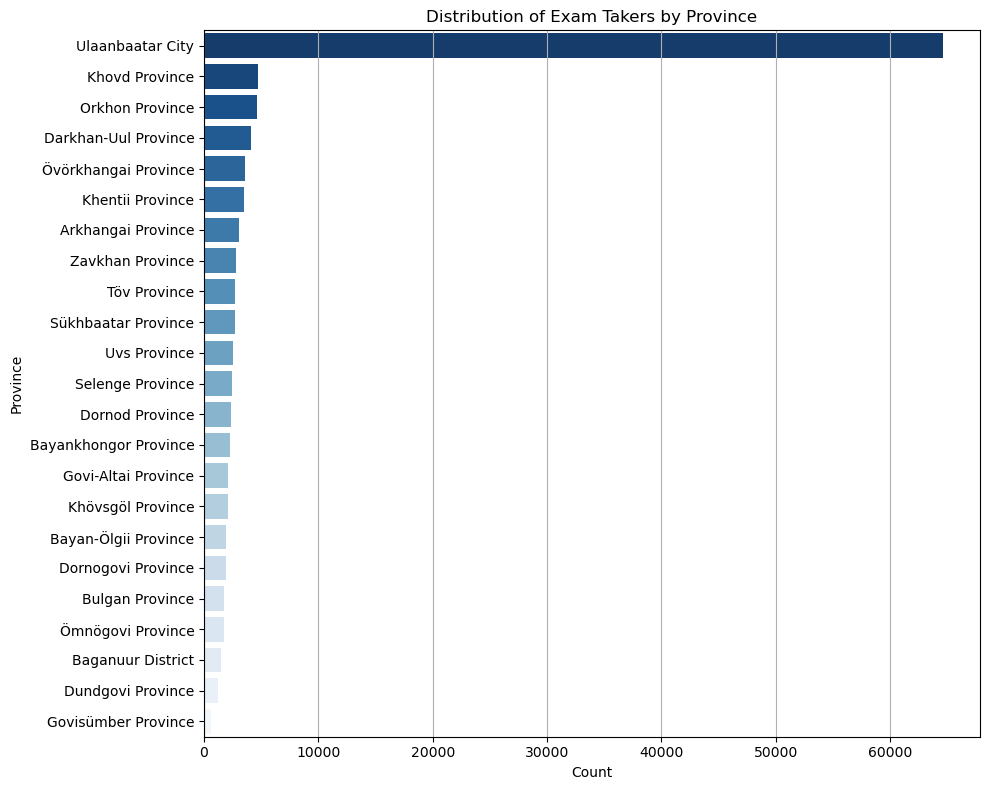

In [42]:
# Bar Chart of Exam Takers by Province
plt.figure(figsize=(10, 8))
sns.countplot(y="Region", data=df, order=df["Region"].value_counts().index, palette="Blues_r")
plt.title("Distribution of Exam Takers by Province")
plt.xlabel("Count")
plt.ylabel("Province")
plt.grid(axis='x')
plt.tight_layout()
plt.show()


### Distribution of Exam Takers by Subject

This bar chart displays the number of exam takers per subject. Mathematics, English, and Social Study are the most commonly taken subjects, reflecting their importance in the entrance exams. In contrast, subjects like History, Geology, and Russian have the least number of examinees, indicating lower participation or availability.


/var/folders/zb/cc1txqfj67jbtr91_h72hwt00000gn/T/ipykernel_6053/2340908687.py:3: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.




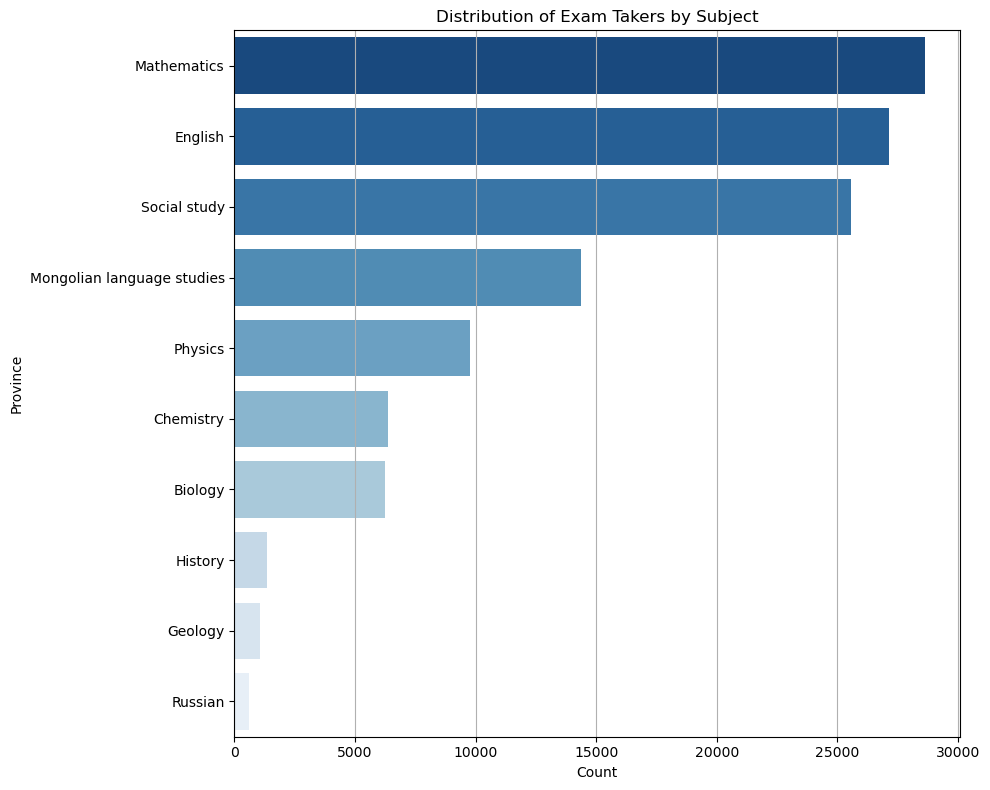

In [43]:
# Bar Chart of Exam Takers by Subject
plt.figure(figsize=(10, 8))
sns.countplot(y="Subject", data=df, order=df["Subject"].value_counts().index, palette="Blues_r")
plt.title("Distribution of Exam Takers by Subject")
plt.xlabel("Count")
plt.ylabel("Province")
plt.grid(axis='x')
plt.tight_layout()
plt.show()


### Scatter Plot of Percentile and Converted Score

This scatter plot shows a curved relationship between Percentile and Converted Score. The curve indicates that score changes have a greater impact on percentile rankings at the lower and upper ends, while the middle percentiles are more evenly spaced.

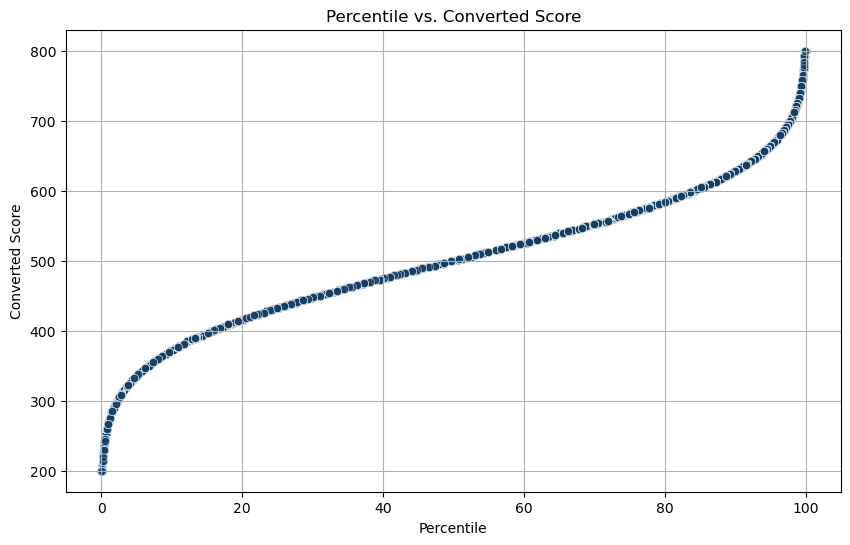

In [44]:
#Percentile vs. Converted Score
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df, x="Percentile", y="Convertedscore", color="#113f67", alpha=0.6)
plt.title("Percentile vs. Converted Score")
plt.xlabel("Percentile")
plt.ylabel("Converted Score")
plt.grid(True)
plt.show()


### Scatter Plot of Percentile and First Score

This chart shows that multiple curved lines are formed, indicating repeated score groupings across percentiles. Unlike the converted scores, which are continuous, the first scores are discrete, leading to layered curves. Each curve represents students with the same first score but varying percentiles. 

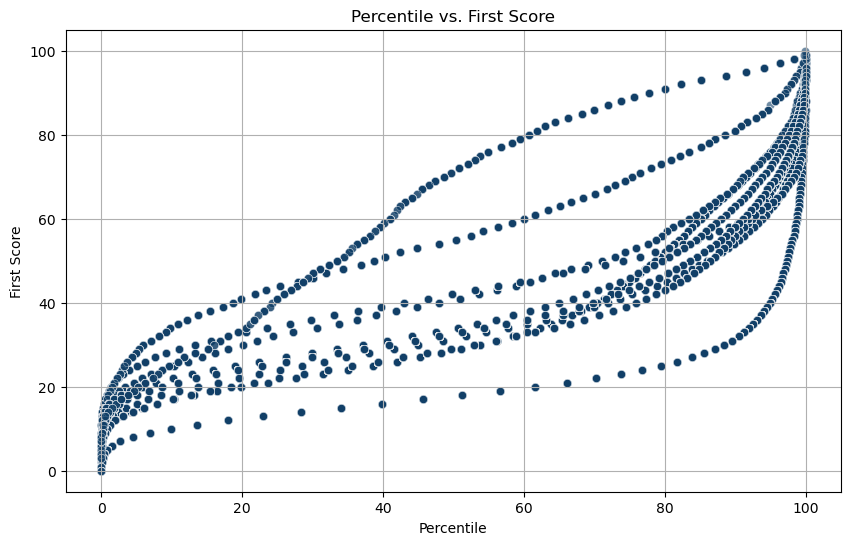

In [45]:
#Percentile vs. Converted Score
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df, x="Percentile", y="Firstscore", color="#113f67", alpha=0.6)
plt.title("Percentile vs. First Score")
plt.xlabel("Percentile")
plt.ylabel("First Score")
plt.grid(True)
plt.show()


### Box Plot of First Scores per Subject
This box plot shows that each subject has a distinct distribution of first scores, highlighting differences in median performance and interquartile range. The variation across subjects reflects the diversity in difficulty level or scoring patterns, with some subjects having more tightly grouped scores and others showing wider spreads or more extreme values.

/var/folders/zb/cc1txqfj67jbtr91_h72hwt00000gn/T/ipykernel_6053/4057214996.py:3: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




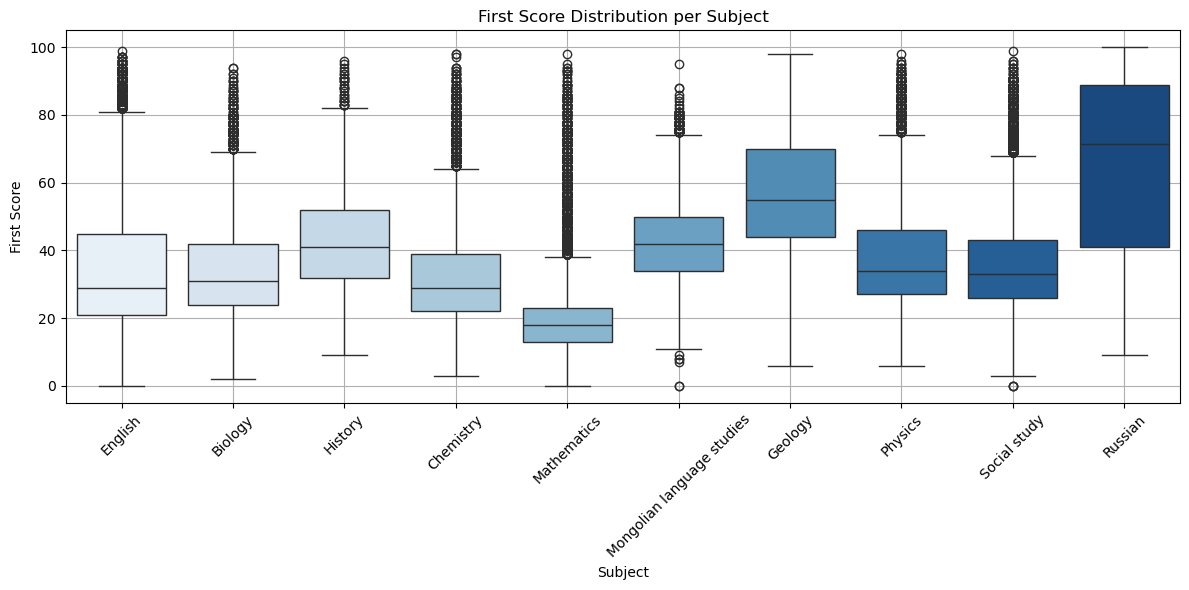

In [46]:
# Box Plot of First Scores per Subject
plt.figure(figsize=(12, 6))
sns.boxplot(
    data=df,
    x="Subject",
    y="Firstscore",
    palette="Blues"
)
plt.title("First Score Distribution per Subject")
plt.xlabel("Subject")
plt.ylabel("First Score")
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


### Line graph of Percentile and First Score with Subject Indicators

This line graph illustrates how multiple curved lines emerge due to the discrete nature of First Scores. These scores are grouped by subject, leading to layered or stepped curves across percentiles. Each line represents a group of students sharing the same score but appearing at different percentile levels, highlighting subject-specific performance patterns.

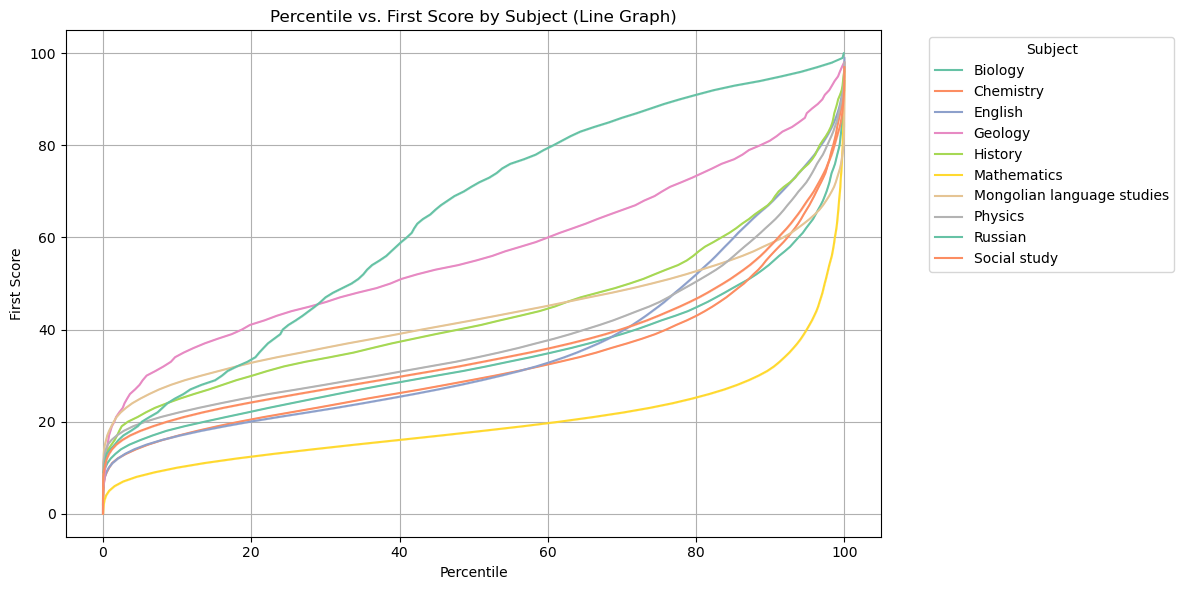

In [47]:
# Line graph of Percentile and First Score with Subject Indicators

df_sorted = df.sort_values(by=["Subject", "Percentile"])

plt.figure(figsize=(12, 6))
sns.lineplot(
    data=df_sorted,
    x="Percentile",
    y="Firstscore",
    hue="Subject",
    palette="Set2"
)
plt.title("Percentile vs. First Score by Subject (Line Graph)")
plt.xlabel("Percentile")
plt.ylabel("First Score")
plt.grid(True)
plt.legend(title="Subject", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


### Line graph of Percentile and Converted with Subject Indicators

This line graph shows the relationship between percentile and converted scores across subjects. Many of these lines stick closely together or overlap, indicating that across subjects, students tend to have similar converted scores at corresponding percentiles. 

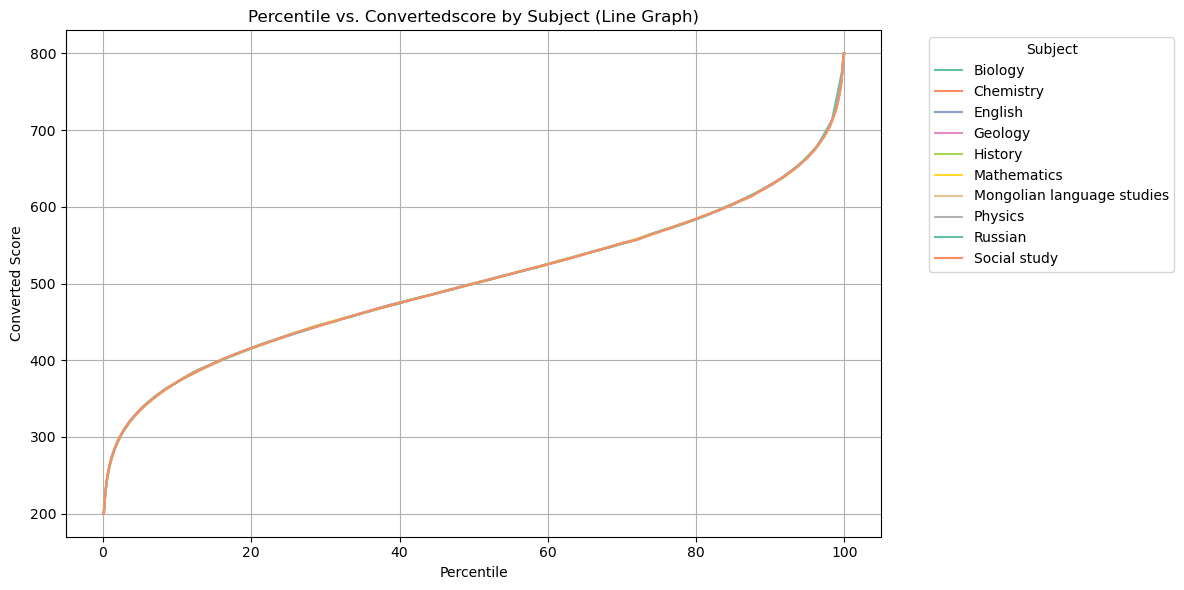

In [48]:
# Line graph of Percentile and Converted with Subject Indicators
df_sorted = df.sort_values(by=["Subject", "Percentile"])

plt.figure(figsize=(12, 6))
sns.lineplot(
    data=df_sorted,
    x="Percentile",
    y="Convertedscore",
    hue="Subject",
    palette="Set2"
)
plt.title("Percentile vs. Convertedscore by Subject (Line Graph)")
plt.xlabel("Percentile")
plt.ylabel("Converted Score")
plt.grid(True)
plt.legend(title="Subject", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


### Scatter Plot of Percentile and Converted with Subject Indicators

This scatter plot presents the distribution of First Scores across Percentiles, categorized by Region. While multiple regions are represented, the color dominance in the graph reveals that a majority of exam takers come from a single region as indicated by the concentration of one color. This highlights regional disparities in participation, with specific province contributing significantly more students to the national exam results.

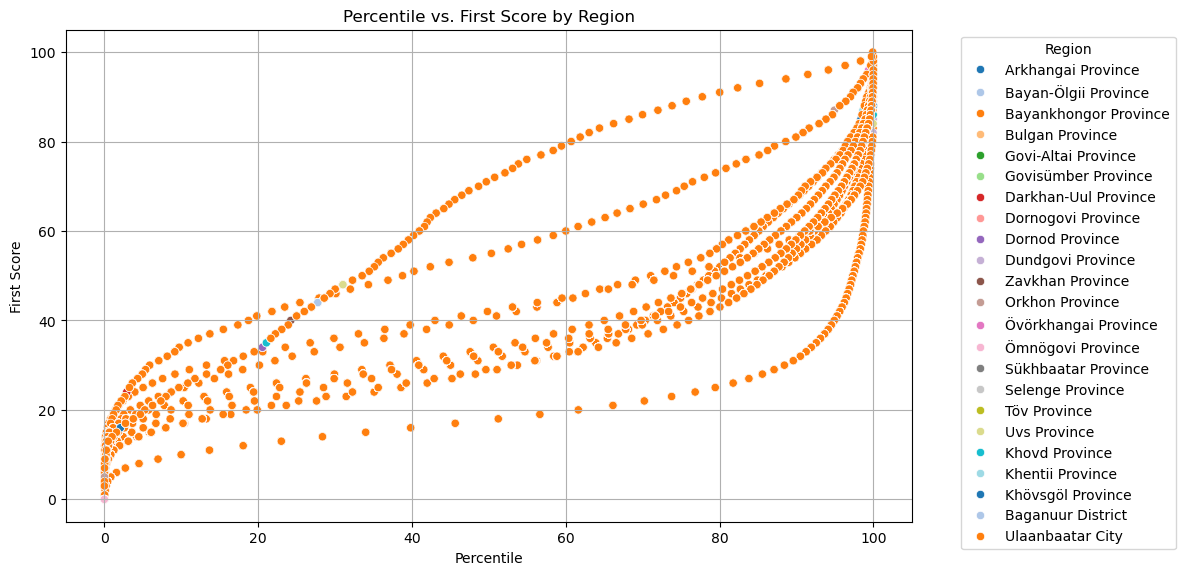

In [49]:
plt.figure(figsize=(12, 6))
sns.scatterplot(
    data=df,
    x="Percentile",
    y="Firstscore",
    hue="Region",
    palette="tab20",
)
plt.title("Percentile vs. First Score by Region")
plt.xlabel("Percentile")
plt.ylabel("First Score")
plt.grid(True)
plt.legend(title="Region", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


## Modeling and Prediction

### ECDF as a Subject-Specific Percentile Prediction Tool for First Scores

In modeling for the prediction of First Scores, ECDF (Empirical Cumulative Distribution Function) is used because it is a non-parametric statistical tool that estimates the cumulative probability distribution of a dataset. ECDF is particularly useful for mapping individual scores to their percentile rankings without making assumptions about the underlying data distribution.

Since there are multiple subjects, each with distinct score distributions—as observed in the previous graphs—the ECDF allows for subject-specific percentile prediction without the need to train separate machine learning models per subject. This makes it a computationally efficient and interpretable approach for percentile estimation based on First Scores.

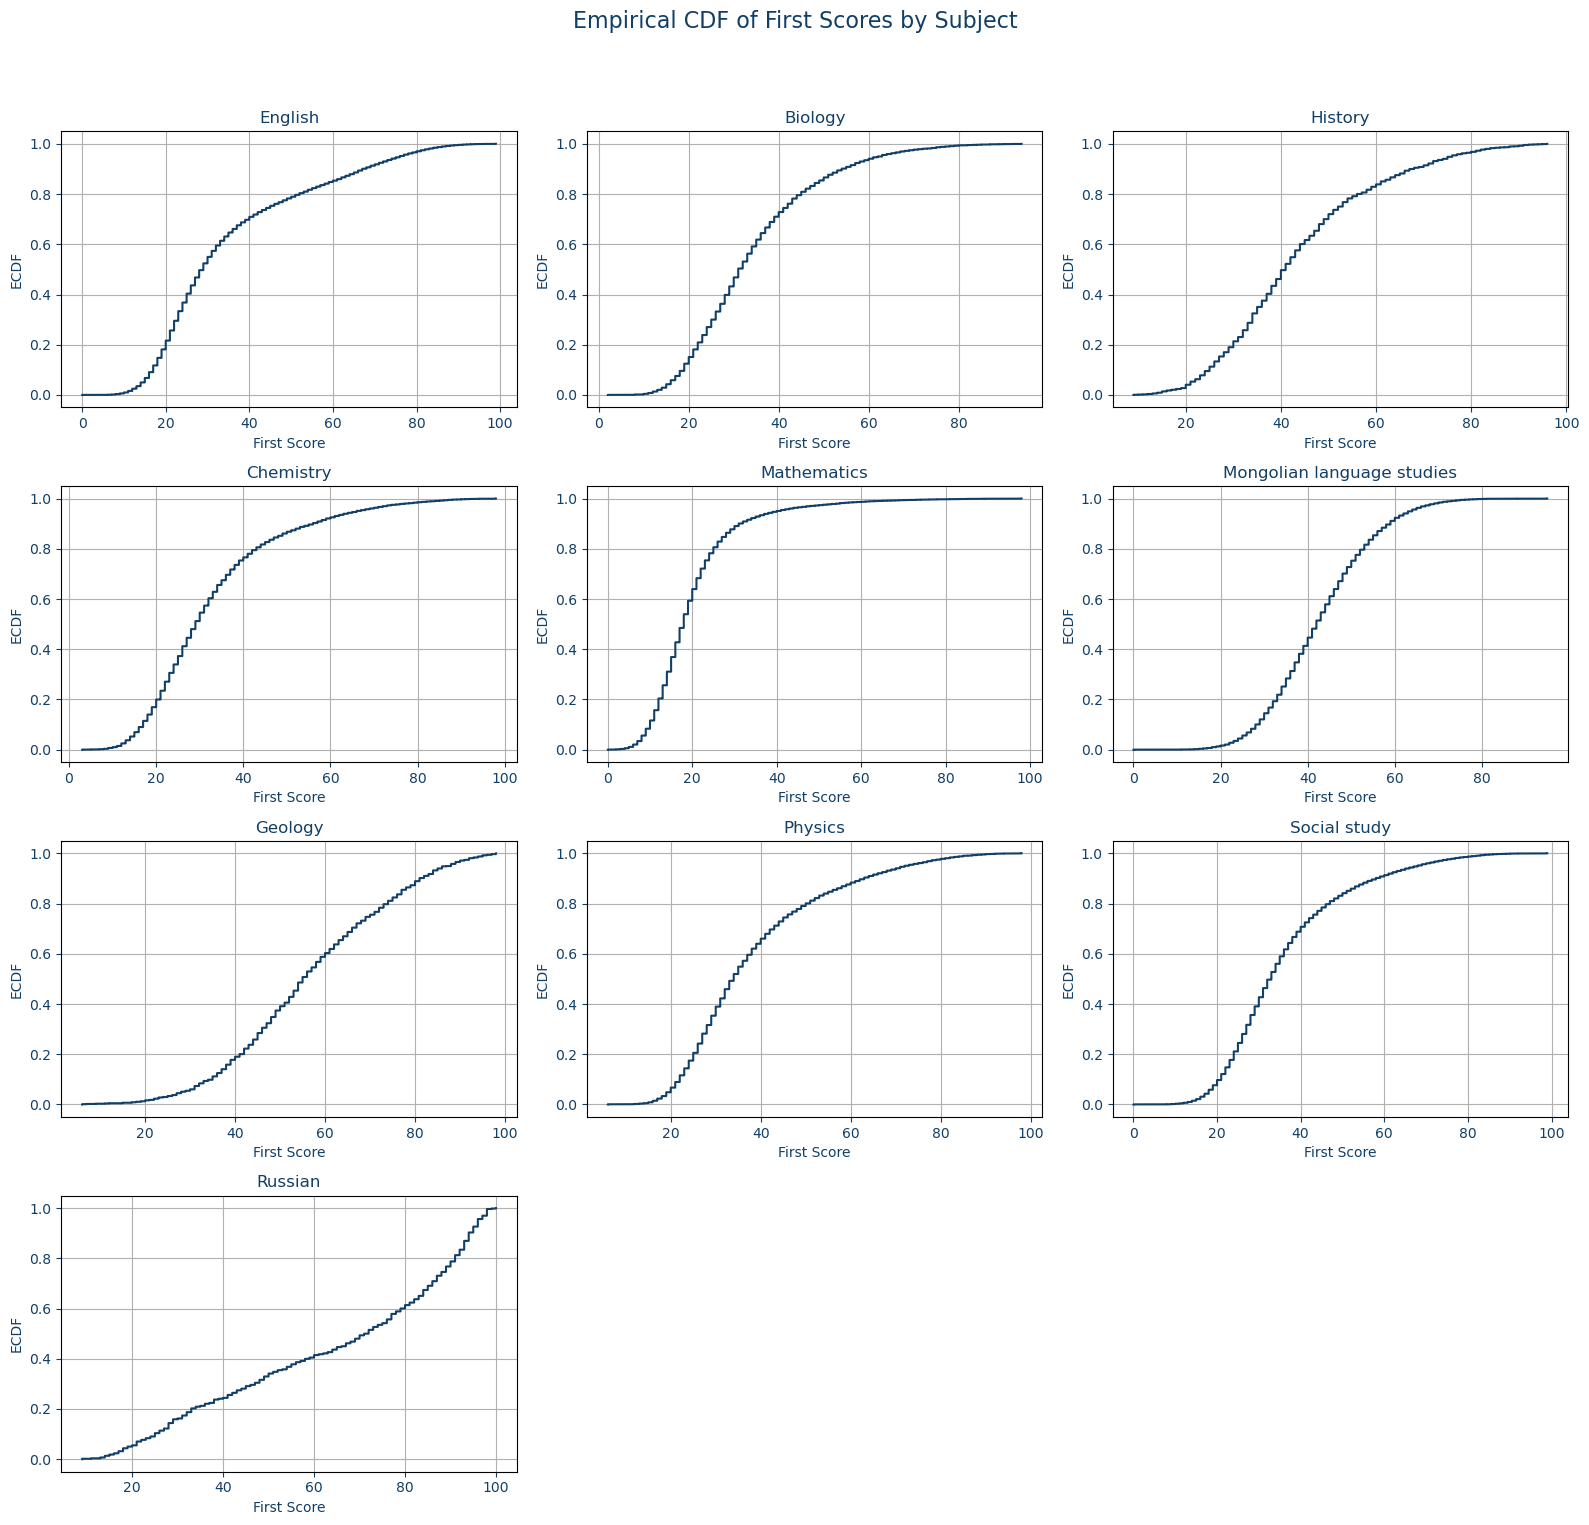

In [50]:
# Using ECDF for Subject Specific Percentile Prediction for First Scores
subjects = df['Subject'].dropna().unique()
n_cols = 3
n_rows = -(-len(subjects) // n_cols)

fig, axes = plt.subplots(n_rows, n_cols, figsize=(16, n_rows * 4))
axes = axes.flatten()

for i, subject in enumerate(subjects):
    ax = axes[i]

    subject_scores = df[df['Subject'] == subject]['Firstscore'].dropna()
    ecdf = ECDF(subject_scores)
    ax.step(ecdf.x, ecdf.y, where='post', color="#113f67")

    ax.set_title(subject, fontsize=12, color="#113f67")
    ax.set_xlabel("First Score", color="#113f67")
    ax.set_ylabel("ECDF", color="#113f67")
    ax.tick_params(axis='x', colors="#113f67")
    ax.tick_params(axis='y', colors="#113f67")
    ax.grid(True)

for j in range(len(subjects), len(axes)):
    fig.delaxes(axes[j])

plt.suptitle("Empirical CDF of First Scores by Subject", fontsize=16, color="#113f67")
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()


### Random Forest for Percentile Prediction from Converted Scores

In this model, a Random Forest Regressor which is an ensemble learning method built from multiple decision trees was used to predict student percentiles based on their Converted Scores. This approach was chosen because of its ability to handle nonlinear relationships, reduce overfitting, and maintain high prediction accuracy across various data distributions.


In [51]:
# Random Forest for Percentile Prediction from Converted Scores
df = pd.read_csv("Combined Dataset.csv")
df = df[["Convertedscore", "Percentile"]].dropna()
X = df[["Convertedscore"]]
y = df["Percentile"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

joblib.dump(model, "rf_percentile_model.pkl")
y_pred = model.predict(X_test)
r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
print(f"R² Score: {r2:.3f} | MAE: {mae:.4f}")


R² Score: 1.000 | MAE: 0.0280


## Visualize

The following graphs are presented here as static representations to support the analysis and explanations provided. However, in the actual dashboard, these visualizations are fully interactive allowing users to hover, filter, and explore data dynamically by subject, province, or score range. This static view simply helps illustrate key trends and interpretations discussed throughout the documentation.

### Bubble Chart: Percentile vs. First Score by Subject
This visualization presents a bubble chart showing the relationship between students’ percentile ranks and their first scores across various subjects. Each bubble represents a group of students who share the same first score and percentile value, while the size of each bubble corresponds to the number of students in that grouping. This makes it easy to identify areas where many students fall within similar performance levels. As seen in the chart, larger bubbles tend to appear in the middle percentile range, indicating that most students are concentrated around the average scores. On the other hand, fewer students are observed at the extreme high or low percentiles, which are reflected by smaller bubbles. The color of each bubble reflects the subject, helping to distinguish performance patterns across subjects in a single view. This plot effectively captures both the density and distribution of exam outcomes across subjects, scores, and percentile ranks.

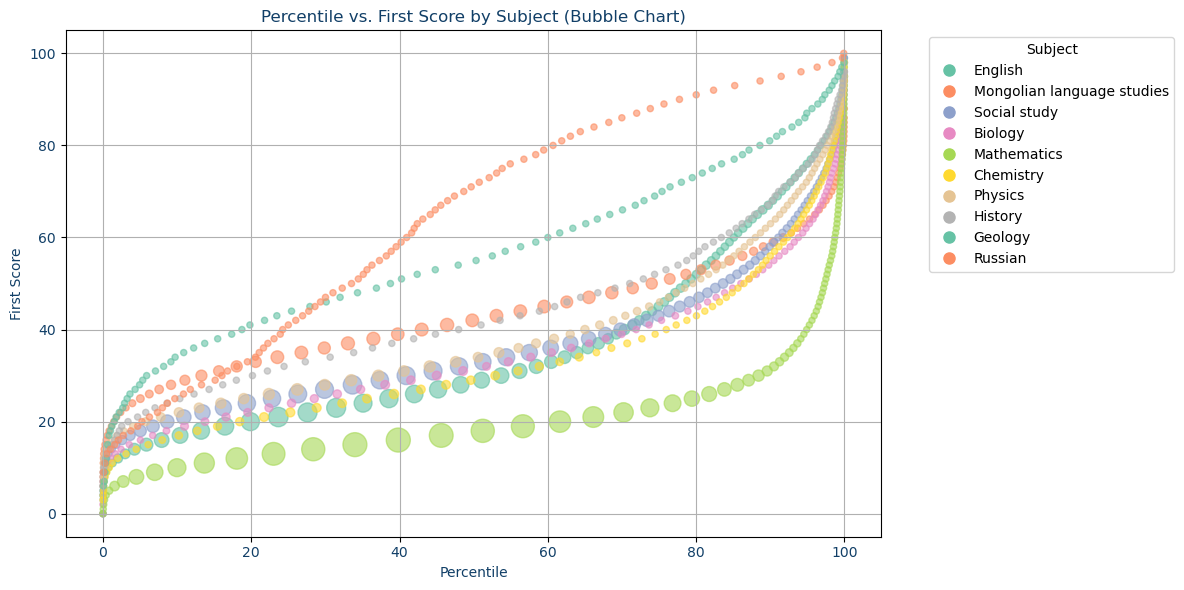

In [52]:
df = pd.read_csv("Combined Dataset.csv")

bubble_df = (
    df.groupby(["Percentile", "Firstscore", "Subject"])
    .size()
    .reset_index(name="Count")
)

max_bubble_size = 300
min_bubble_size = 20
max_count = bubble_df["Count"].max()
bubble_df["Size"] = bubble_df["Count"] / max_count * max_bubble_size
bubble_df["Size"] = bubble_df["Size"].clip(lower=min_bubble_size)

subjects = bubble_df["Subject"].unique()
colors = plt.cm.Set2.colors
color_map = {subject: colors[i % len(colors)] for i, subject in enumerate(subjects)}

plt.figure(figsize=(12, 6))
for subject in subjects:
    subject_data = bubble_df[bubble_df["Subject"] == subject]
    plt.scatter(
        subject_data["Percentile"],
        subject_data["Firstscore"],
        s=subject_data["Size"],
        alpha=0.6,
        color=color_map[subject],
        label=subject
    )
legend_handles = [
    mlines.Line2D([], [], color=color_map[subj], marker='o', linestyle='None', markersize=8, label=subj)
    for subj in subjects
]
plt.legend(
    handles=legend_handles,
    title="Subject",
    bbox_to_anchor=(1.05, 1),
    loc="upper left"
)
plt.title("Percentile vs. First Score by Subject (Bubble Chart)", color="#113f67")
plt.xlabel("Percentile", color="#113f67")
plt.ylabel("First Score", color="#113f67")
plt.xticks(color="#113f67")
plt.yticks(color="#113f67")
plt.grid(True)
plt.tight_layout()
plt.show()


### Percentile-Based Score Requirements Table
This table summarizes the required First Score and Converted Score thresholds to reach specific percentile ranks (90th, 75th, 60th, 50th, 40th, and 25th) across each subject. By grouping students by subject and computing quantile values, it provides a clear reference of what score levels correspond to each percentile tier. This approach allows for direct comparison across subjects and helps in identifying performance benchmarks. Unlike graphs, this table offers a more precise numerical view of score requirements for targeted percentile goals, making it useful for educators, policymakers, and students alike.


In [53]:
# Percentile-Based Score Requirements Table
df = df[["Subject", "Firstscore", "Convertedscore"]].dropna()

percentiles = [(0.9, "90th"), (0.75, "75th"), (0.6, "60th"),
               (0.5, "50th"), (0.4, "40th"), (0.25, "25th")]

rows = []
for subject, group in df.groupby("Subject"):
    for p_val, p_label in percentiles:
        firstscore = group["Firstscore"].quantile(p_val)
        convertedscore = group["Convertedscore"].quantile(p_val)
        rows.append({
            "Percentile": p_label,
            "Subject": subject,
            "First Score": round(firstscore, 2),
            "Converted Score": round(convertedscore, 2)
        })

percentile_table = pd.DataFrame(rows)
percentile_table = percentile_table.sort_values(
    by=["Subject", "Percentile"],
    ascending=[True, False]
).reset_index(drop=True)

percentile_table

,Percentile,Subject,First Score,Converted Score
0,90th,Biology,54.0,627.0
1,75th,Biology,42.0,569.0
2,60th,Biology,35.0,527.0
3,50th,Biology,31.0,496.0
4,40th,Biology,29.0,479.0
5,25th,Biology,24.0,434.0
6,90th,Chemistry,56.0,628.0
7,75th,Chemistry,39.0,566.0
8,60th,Chemistry,32.0,522.0
9,50th,Chemistry,29.0,499.0


### Choropleth Map of Exam Takers by Region

This choropleth map visualizes the distribution of exam takers across Mongolia by province using ISO codes mapped to geographic boundaries. Darker shades represent higher exam counts, while lighter shades indicate fewer participants. As shown in the map, Ulaanbaatar City overwhelmingly dominates in exam participation, reflecting its dense population and central role in the country’s education system. The map provides a clear spatial representation of regional disparities in test taker volume, which can inform resource allocation and regional education strategies.

In [54]:
df = pd.read_csv("Combined Dataset.csv")

# Choropleth Map of Exam Takers by Region
df["ISO_Code"] = df["ISO_Code"].str.replace("-", "")

plotly_data = df.groupby(["ISO_Code", "Region"]).size().reset_index(name="Exam Count")

with open("mn.json", "r", encoding="utf-8") as f:
    geojson = json.load(f)

fig = px.choropleth_mapbox(
    plotly_data,
    geojson=geojson,
    locations="ISO_Code",
    featureidkey="properties.id",
    color="Exam Count",
    hover_name="Region",
    mapbox_style="carto-positron",
    zoom=4.5,
    center={"lat": 46.86, "lon": 103.84},
    opacity=0.6,
    color_continuous_scale=["#e6f6ff", "#113f67"]
)
fig.update_layout(
    height=400,
    margin={"r": 0, "t": 0, "l": 0, "b": 0},
    coloraxis_showscale=False
)
fig.show()


/var/folders/zb/cc1txqfj67jbtr91_h72hwt00000gn/T/ipykernel_6053/261507894.py:11: DeprecationWarning:

*choropleth_mapbox* is deprecated! Use *choropleth_map* instead. Learn more at: https://plotly.com/python/mapbox-to-maplibre/



### First and Converted Score and Grade Distributions
This set of side-by-side visualizations illustrates the overall distribution patterns of student scores and grade indices in the exam dataset:

***First Scores Distribution***: The histogram shows that most students scored on the lower end of the Firstscore range, with the distribution skewed left. This reflects a higher concentration of raw scores at lower values.

***Converted Scores Distribution***: In contrast, the Convertedscore histogram is more evenly distributed, indicating that the normalization or scaling process effectively spread the scores more uniformly across the range.

***Letter Index Distribution***: The Letterindex bar chart reveals that most students fall into lower-grade brackets, especially around "F" and "D-" levels. The sharp left-sided distribution indicates that higher letter grades were achieved by fewer students.

Together, these plots give a clear picture of student performance: while many scored low initially, the converted scores help normalize results; however, the letter grade system still reflects overall performance clustering in the lower bands.

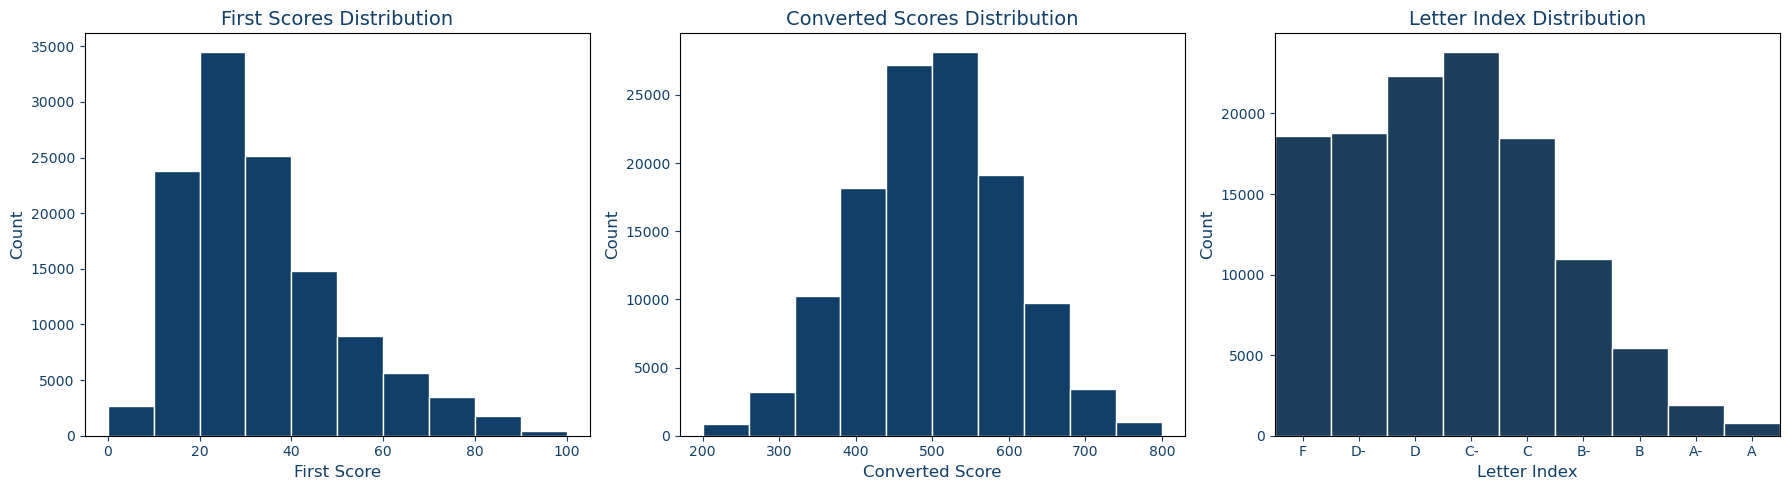

In [55]:
main_color = "#113f67"
label_font = dict(size=12, color=main_color)
title_font = dict(size=14, color=main_color)

fig, axes = plt.subplots(1, 3, figsize=(18, 5), sharey=False)
sns.histplot(
    data=df,
    x="Firstscore",
    bins=10,
    color=main_color,
    edgecolor="white",
    alpha=1,
    ax=axes[0]
)
axes[0].set_title("First Scores Distribution", **title_font)
axes[0].set_xlabel("First Score", **label_font)
axes[0].set_ylabel("Count", **label_font)
axes[0].tick_params(colors=main_color)
sns.histplot(
    
    data=df,
    x="Convertedscore",
    bins=10,
    color=main_color,
    edgecolor="white",
    alpha=1,
    ax=axes[1]
)
axes[1].set_title("Converted Scores Distribution", **title_font)
axes[1].set_xlabel("Converted Score", **label_font)
axes[1].set_ylabel("Count", **label_font)
axes[1].tick_params(colors=main_color)
letter_order = ['F','D-','D','C-','C','B-','B','A-','A']

sns.countplot(
    data=df,
    x="Letterindex",
    order=letter_order,
    color=main_color,
    edgecolor="white",
    alpha=1,
    width=1,
    ax=axes[2]
)
axes[2].set_title("Letter Index Distribution", **title_font)
axes[2].set_xlabel("Letter Index", **label_font)
axes[2].set_ylabel("Count", **label_font)
axes[2].tick_params(colors=main_color)
plt.tight_layout()
plt.show()
